In [2]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
df = pd.read_csv('../data/preliminary_results.csv')

In [4]:
df

,date,ew,ew_unc,int_wv,qidx,star_name,time,jd
0,2020-09-19,1.066084e+00,2.158865e-02,8542.0,6062.0,HAT-P-32_3_IN,06:39:47,NaN
1,2020-09-19,1.115549e+00,2.340373e-02,8542.0,6062.0,HAT-P-32_3_IN,06:54:00,NaN
2,2020-08-07,1.184028e+00,3.215695e-02,8542.0,4968.0,HAT-P-32_1_OUT_b2,08:43:26,NaN
3,2020-08-07,-1.617869e-02,4.505612e-01,8542.0,4968.0,HAT-P-32_1_OUT_b2,08:57:39,NaN
4,2020-08-07,1.152361e+00,4.073554e-02,8542.0,4968.0,HAT-P-32_1_OUT_b2,09:11:52,NaN
5,2020-08-07,1.146301e+00,2.850835e-02,8542.0,4968.0,HAT-P-32_1_OUT_b2,09:26:05,NaN
6,2020-08-08,1.139007e+00,2.170367e-02,8542.0,4969.0,HAT-P-32_1_OUT_b1,08:42:34,NaN
7,2020-08-08,1.175998e+00,2.079834e-02,8542.0,4969.0,HAT-P-32_1_OUT_b1,08:56:47,NaN
8,2020-08-08,1.135312e+00,1.866167e-02,8542.0,4969.0,HAT-P-32_1_OUT_b1,09:11:00,NaN
9,2020-08-08,1.103793e+00,2.119783e-02,8542.0,4969.0,HAT-P-32_1_OUT_b1,09:25:12,NaN


In [5]:
target_mask = df.star_name.str.contains('HAT-P-32')

In [6]:
df = df[target_mask]

In [16]:
keep_mask = df.ew_unc < 1

In [17]:
df = df[keep_mask]

In [21]:
in_transit_mask = df.star_name.str.contains('_IN')

(0.95, 1.25)

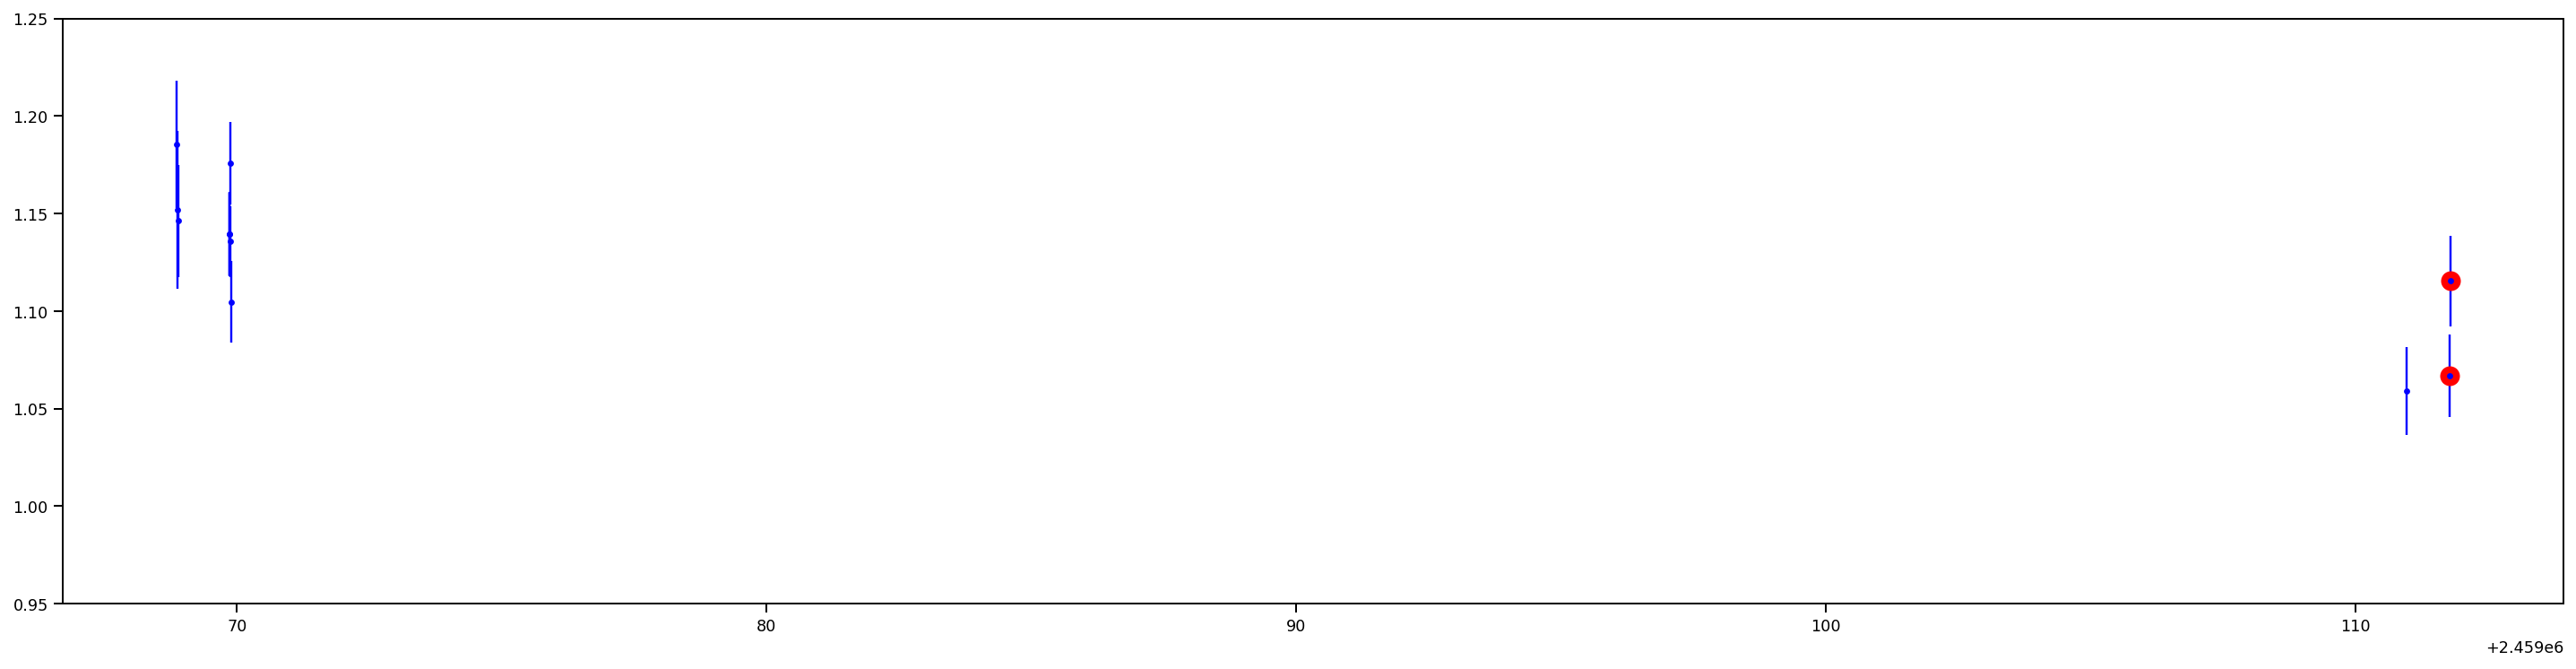

In [27]:
plt.figure(figsize=(25,6))
plt.errorbar(df.jd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.jd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(0.95,1.25)